In [32]:
import matplotlib.pyplot as plt
import json, numpy as np
from pathlib import Path

figpath = Path("/Users/yangjunjie/Downloads")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{color}\usepackage{colortbl}"

data = None
with open('../data/diamond-kmesh-cc-pvdz.json', 'r') as f:
    data = json.load(f)

for k, v in data.items():
    print(k, v)
    break


../benchmark/kmesh/diamond/3-4-4/fftdf-60 {'method': 'fftdf-60', 'basis': 'cc-pvdz', 'natm': 2.0, 'nkpt': 48.0, 'nao': 26.0, 'time_build_df': 0.0, 'naux': 13718.0, 'time_krks': 5.27, 'ene_krks': -11.36484241, 'time_krhf': 411.09, 'ene_krhf': -11.03010976, 'time_kmp2': 2087.22, 'ene_kmp2': -11.29272931, 'ene_corr_kmp2': -0.26261954}


In [33]:
def plot_and_make_table(methods=None, table=None, key="fftdf-60"):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Create figure with custom subplot sizes
    fig = plt.figure(figsize=(9, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])  # 2:1 ratio (8:4)

    ax1 = fig.add_subplot(gs[0])  # First subplot (larger, 8x4 equivalent)
    ax2 = fig.add_subplot(gs[1])  # Second subplot (smaller, 4x4 equivalent)

    # You can still use ax = ax1 if you want to maintain compatibility
    ax = ax1

    colors = {
        "krks": "blue",
        "krhf": "red",
        "kmp2": "green",
        "kccsd": "purple",
    }


    for imethod, method in enumerate(methods):
        x = []
        y = []
        e = []

        for k, v in data.items():
            if not v['method'] == key:
                continue

            if not v.get(f'time_{method}'):
                continue

            x.append(v['nkpt'] * v['natm'])
            y.append(v[f'time_{method}'])
            e.append(v[f'ene_{method}'])

        xx = np.array(x)
        yy = np.array(y)
        ee = np.array(e)
        ix = np.argsort(xx)
        xx = xx[ix]
        yy = yy[ix]
        ee = ee[ix]

        for x, e in zip(xx, ee):
            if not method == methods[-1]:
                continue
            print("natm = %4d, e = %12.6f" % (x, e / v['natm']))
        
        xx = np.log2(xx)
        print(xx, yy)
        a, b = np.polyfit(xx, np.log2(yy), 1)
        ax.semilogy(xx, yy, color=colors[method], marker='o', linestyle='none')
        xx = np.linspace(2, 11, 100)
        ax.semilogy(xx, 2 ** (a * xx + b), color=colors[method], linestyle='dashed', alpha=0.4, label=method.upper())


    x = [v['nkpt'] * v['natm'] for k, v in data.items() if v['method'] == "fftdf-100"]
    x = np.unique(x)
    x.sort()
    x = np.log2(x)

    x = range(2, 12)
    xx = ["$2^{%d}$" % i for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xx)
    ax.set_xlabel(r'$N_{\mathrm{atom}}$', fontsize=16)
    ax.set_ylabel('Time (s)', fontsize=16)
    # ax.set_title('Diamond', fontsize=14)
    ax.set_xlim(2, 11)
    ax.set_ylim(0.5, 3600 * 20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=12, bbox_to_anchor=(0.0, 1.12), framealpha=0, ncol=4, loc='upper left', columnspacing=1.2)

    ax = ax2
    # delete frame 
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # make a Latex table with the energy of each method
    method = methods[-1]
    color = colors[method]

    x = []
    y = []

    for k, v in data.items():
        if not v['method'] == key:
            continue

        if not v.get(f'ene_{method}'):
            continue

        x.append(v['nkpt'] * v['natm'])
        y.append(v[f'ene_{method}'] / v['natm'])

    xx = np.array(x)
    yy = np.array(y)
    ix = np.argsort(xx)
    xx = xx[ix]
    yy = yy[ix]

    dd = {}
    for x, y in zip(xx, yy):
        dd[x] = y

    # make the space larger
    content = r"\renewcommand{\arraystretch}{1.8} \begin{tabular}{cc} "
    content += r"\hline "
    content += r"$N_{\mathrm{atom}}$ & Energy Per Atom ($E_{\mathrm{h}}$) \\ "
    content += r"\hline "

    for x, d in table:
        # make the d to be blue
        n = "%.6f" % dd[x]
        content += r"%d & ${\bf %s} %s$ \\ " % (x, n[:(d+3)], n[(d+3):])

    content += r"\hline "
    content += r"\end{tabular}"

    scaling = a
    ax.text(0.2, 1.05, "Method: %s %s" % (key.split('-')[0].upper(), method.upper()), fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.95, "Scaling: $N^{%6.2f}$" % scaling, fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.85, content, fontsize=16, ha='left', va='top')
    plt.tight_layout()
    plt.show()

    fig_file_name = "diamond-kpt-scaling-%d-%s.png" % (index, key)
    fig.savefig(figpath / fig_file_name, bbox_inches='tight', dpi=600)
    print("save figure to %s" % fig_file_name)


natm =    4, e =    -5.389871
natm =    8, e =    -5.547877
natm =   16, e =    -5.625933
natm =   24, e =    -5.654319
natm =   36, e =    -5.670288
natm =   54, e =    -5.674403
natm =   72, e =    -5.679606
natm =   96, e =    -5.682421
natm =  128, e =    -5.682938
natm =  160, e =    -5.684125
natm =  200, e =    -5.684757
natm =  250, e =    -5.684842
natm = 1024, e =    -5.685503
[ 2.          3.          4.          4.5849625   5.169925    5.7548875
  6.169925    6.5849625   7.          7.32192809  7.64385619  7.96578428
 10.        ] [ 1.86  0.73  1.04  1.62  2.87  2.32  2.7   5.27  5.39  6.53  6.3   7.16
 32.27]


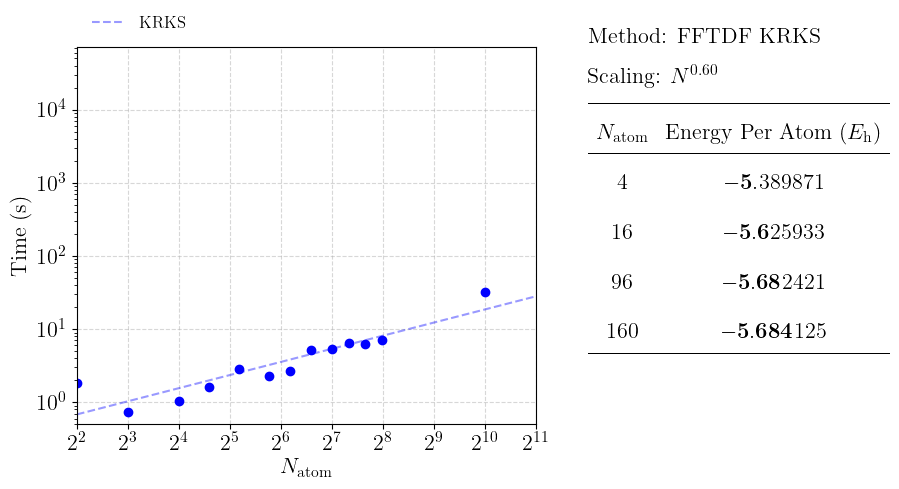

save figure to diamond-kpt-scaling-1-fftdf-60.png


In [43]:
table = [
    (4, 0),
    (16, 1),
    (96, 2),
    (160, 3),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krks"]
plot_and_make_table(methods, table, key)

[ 2.          3.          4.          4.5849625   5.169925    5.7548875
  6.169925    6.5849625   7.          7.32192809  7.64385619  7.96578428
 10.        ] [ 1.86  0.73  1.04  1.62  2.87  2.32  2.7   5.27  5.39  6.53  6.3   7.16
 32.27]
natm =    4, e =    -5.288410
natm =    8, e =    -5.414627
natm =   16, e =    -5.478611
natm =   24, e =    -5.499763
natm =   36, e =    -5.510738
natm =   54, e =    -5.511123
natm =   72, e =    -5.513956
natm =   96, e =    -5.515055
natm =  128, e =    -5.514334
natm =  160, e =    -5.514606
natm =  200, e =    -5.514553
natm =  250, e =    -5.514149
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428] [1.87000e+00 6.58000e+00 2.12100e+01 5.09900e+01 9.58400e+01 2.73310e+02
 2.40920e+02 4.11090e+02 7.82840e+02 1.65613e+03 1.78066e+03 3.66132e+03]


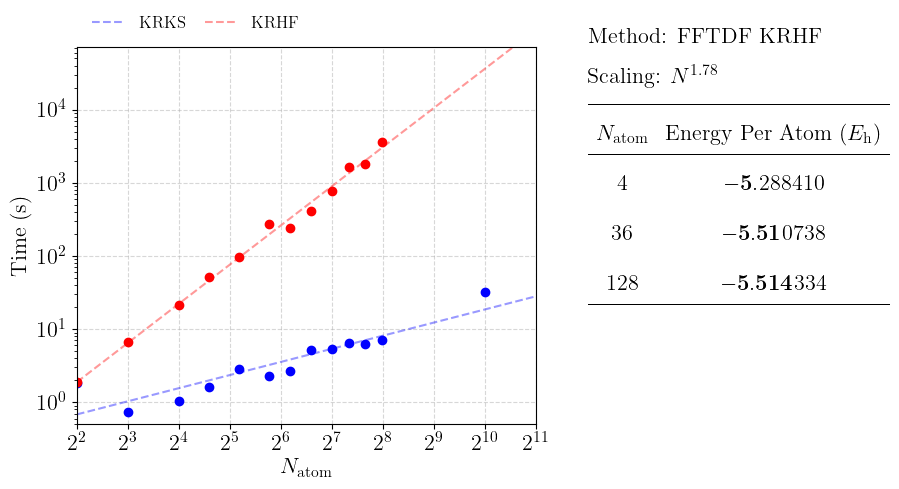

save figure to diamond-kpt-scaling-1-fftdf-60.png


In [47]:
table = [
    (4, 0),
    (36, 2),
    (128, 3),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krks", "krhf"]
plot_and_make_table(methods, table, key)

[ 2.          3.          4.          4.5849625   5.169925    5.7548875
  6.169925    6.5849625   7.          7.32192809  7.64385619  7.96578428
 10.        ] [ 1.86  0.73  1.04  1.62  2.87  2.32  2.7   5.27  5.39  6.53  6.3   7.16
 32.27]
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428] [1.87000e+00 6.58000e+00 2.12100e+01 5.09900e+01 9.58400e+01 2.73310e+02
 2.40920e+02 4.11090e+02 7.82840e+02 1.65613e+03 1.78066e+03 3.66132e+03]
natm =    4, e =    -5.397264
natm =    8, e =    -5.529147
natm =   16, e =    -5.595986
natm =   24, e =    -5.622711
natm =   36, e =    -5.636890
natm =   54, e =    -5.638588
natm =   72, e =    -5.643869
natm =   96, e =    -5.646365
natm =  128, e =    -5.646122
[2.        3.        4.        4.5849625 5.169925  5.7548875 6.169925
 6.5849625 7.       ] [2.60000e-01 2.70000e+00 1.90700e+01 7.77800e+01 1.81030e+02 6.66760e+02
 9.27460e+02 2.08722e+03 5.17844e+03]


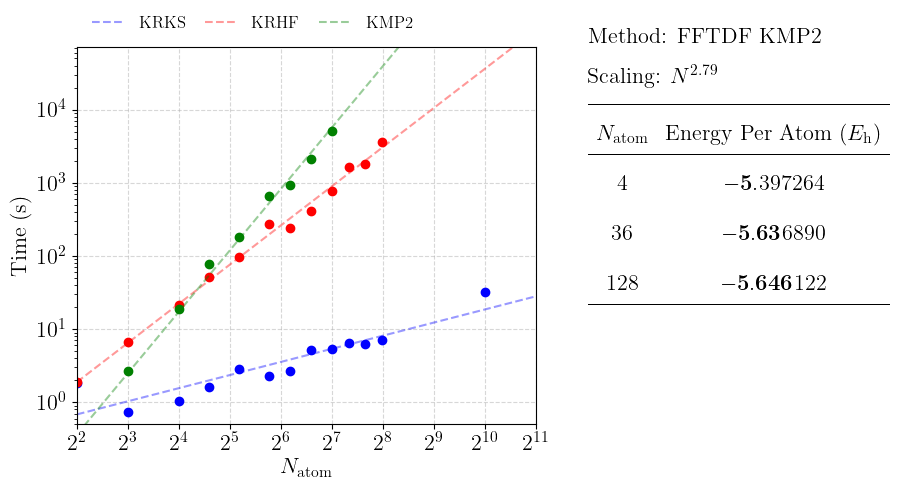

save figure to diamond-kpt-scaling-1-fftdf-60.png


In [ ]:
table = [
    (4, 0),
    (36, 1),
    (72, 2),
    (128, 3),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krks", "krhf", "kmp2"]
plot_and_make_table(methods, table, key)